In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, Reduction

import ethicml

In [2]:
class AlwaysDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        # always set training to 'True'
        return super().call(inputs, training=True)

In [3]:
keep_prob = 0.9
length_scale = 1.0
precision = 100.0
batch_size = 32
hidden_units = 100

In [4]:
weight_decay = (keep_prob * length_scale**2) / (2 * batch_size * precision)
NN_drop = tf.keras.Sequential([
    AlwaysDropout(1 - keep_prob),
    Dense(hidden_units, activation="tanh", kernel_regularizer=l2(weight_decay),
          use_bias=True, bias_regularizer=l2(weight_decay)),
    AlwaysDropout(1 - keep_prob),
    Dense(1, activation=None, kernel_regularizer=l2(weight_decay),
          use_bias=False)
])

In [5]:
NN = tf.keras.Sequential([
    Dropout(1 - keep_prob),
    Dense(hidden_units, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
          use_bias=True, bias_regularizer=tf.keras.regularizers.l2(weight_decay)),
    Dropout(1 - keep_prob),
    Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
          use_bias=False)
])

In [6]:
NN_simple = tf.keras.Sequential([
    Dense(hidden_units, activation="tanh", use_bias=True),
    Dense(1, activation=None, use_bias=False)
])

In [7]:
train_dt, test_dt = ethicml.evaluators.evaluate_models.train_test_split(
    ethicml.data.load.load_data(ethicml.data.Adult()))

In [8]:
def _to_dataset(dt, mean_and_std=None):
    x, s, y = dt
    x, y = x.to_numpy(), y.to_numpy().astype(np.float32)
    if mean_and_std is None:
        mean_and_std = np.mean(x, axis=0), np.std(x, axis=0)
        
    x = (x - mean_and_std[0]) / mean_and_std[1]
    return tf.data.Dataset.from_tensor_slices((x, y)), y, s, mean_and_std

In [9]:
train_ds, y_train, _, mean_and_std = _to_dataset(train_dt)
test_ds, y_test, s_test, _ = _to_dataset(test_dt, mean_and_std=mean_and_std)

train_ds = train_ds.shuffle(len(y_train), seed=888).batch(batch_size, drop_remainder=True)
test_ds = test_ds.batch(len(y_test))

In [10]:
learning_rate = 0.005
epochs = 10

In [11]:
for model in [NN_drop, NN, NN_simple]:
    model.compile(
        optimizer=Adam(lr=learning_rate),
        loss=BinaryCrossentropy(from_logits=True, reduction=Reduction.SUM_OVER_BATCH_SIZE),
        metrics=['accuracy'],
    )
    model.fit(train_ds, epochs=epochs, validation_data=test_ds, validation_freq=1)

Epoch 1/10
1221/1221 [==============================] - 3s 2ms/step - loss: 0.3782 - accuracy: 0.8226 - val_loss: 0.3665 - val_accuracy: 0.8285
Epoch 2/10
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3561 - accuracy: 0.8379 - val_loss: 0.3593 - val_accuracy: 0.8295
Epoch 3/10
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3532 - accuracy: 0.8416 - val_loss: 0.3658 - val_accuracy: 0.8298
Epoch 4/10
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3557 - accuracy: 0.8409 - val_loss: 0.3554 - val_accuracy: 0.8349
Epoch 5/10
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3546 - accuracy: 0.8393 - val_loss: 0.3596 - val_accuracy: 0.8297
Epoch 6/10
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3530 - accuracy: 0.8421 - val_loss: 0.3599 - val_accuracy: 0.8338
Epoch 7/10
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3527 - accuracy: 0.8401 - val_loss: 0.3609 - val_accuracy:

In [12]:
pred_baseline = tf.sigmoid(NN.predict(test_ds)).numpy()
pred_simple = tf.sigmoid(NN_simple.predict(test_ds)).numpy()

In [13]:
repeats = 30
results = []
for _ in range(repeats):
#     results.append(NN_drop.predict(test_ds))
    results.append(tf.sigmoid(NN_drop.predict(test_ds)).numpy())
results = np.stack(results, axis=0)
# pred_dropout = tf.sigmoid(results.mean(axis=0)).numpy()
pred_dropout = results.mean(axis=0)

In [14]:
def bin_data(data, num_bins):
    """Put the given data into bins
    Args:
        data: the data to put into bins
        num_bins: the number of bins
    Returns:
        an array of the same size as data with the corresponding bin indices and an array of values
        that are associated with each bin
    """
    # separate the data range into equal sized bins
    # nonlinear methods would also be possible
    bin_edges = np.linspace(data.min(), data.max(), num_bins + 1)
    bin_indices = np.digitize(data, bin_edges, right=True)
    # we associate a value with each bin by taking the average of the bin edges
    bin_values = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    return bin_indices, bin_values

In [15]:
def binned_positive_label_prob(labels, bin_indices, num_bins):
    """Compute the probability of a positive label for binned data
    Args:
        labels: the labels with which to compute the probability
        bin_indices: the binned data
        num_bins: the number of bins in the binned data
    Returns:
        an array with the positive label probability for each bin
    """
    pos_prob = np.zeros(num_bins)
    for i in range(num_bins):
        bin_index = i + 1
        pos_prob[i] = np.mean(labels[bin_indices == bin_index])
    return pos_prob

In [16]:
def confidence_and_pos_prob(scores, labels, groups=None, group_id=0):
    num_bins = 20
    if groups is not None:
        scores = scores[groups == group_id]
        labels = labels[groups == group_id]
    indices, confidence = bin_data(scores, num_bins)
    pos_prob = binned_positive_label_prob(labels, indices, num_bins)
    return confidence, pos_prob

In [17]:
conf_baseline, pos_baseline = confidence_and_pos_prob(pred_baseline, y_test)
conf_simple, pos_simple = confidence_and_pos_prob(pred_simple, y_test)
conf_dropout, pos_dropout = confidence_and_pos_prob(pred_dropout, y_test)

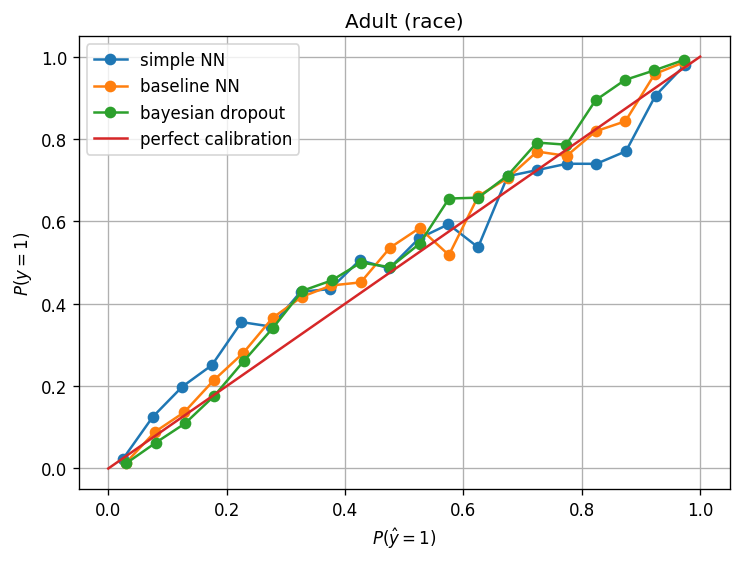

In [18]:
fig, plot = plt.subplots(figsize=(7, 5), dpi=120)
plot.plot(conf_simple, pos_simple, 'o-', label='simple NN')
plot.plot(conf_baseline, pos_baseline, 'o-', label='baseline NN')
plot.plot(conf_dropout, pos_dropout, 'o-', label='bayesian dropout')
plot.plot([0, 1], [0, 1], label='perfect calibration')
#plot.plot([0.48, 0.52], [0.48, 0.52])
plot.set_title('Adult (race)')
plot.set_xlabel('$P(\\hat{y}=1)$')
plot.set_ylabel('$P(y=1)$')
plot.grid()
plot.legend()

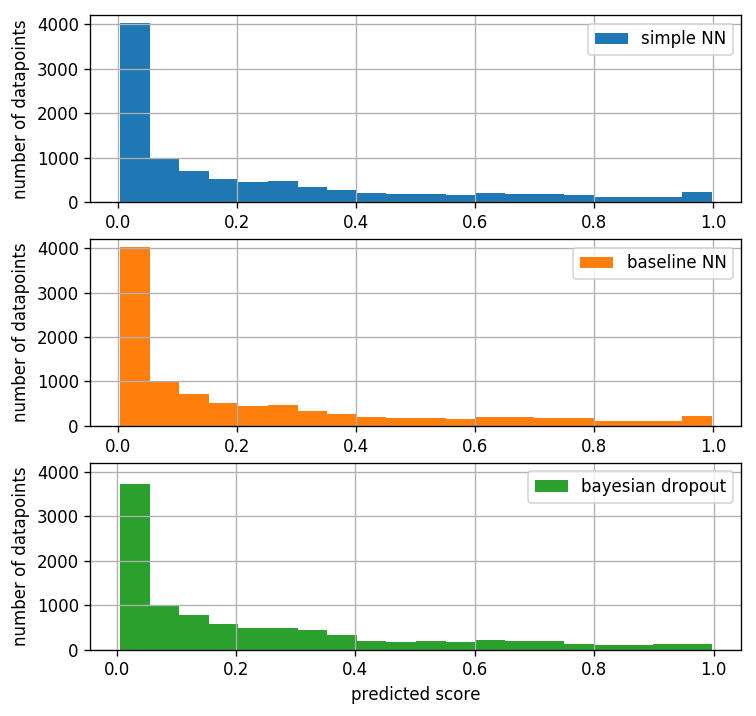

In [19]:
fig, plots = plt.subplots(nrows=3, figsize=(7, 7), dpi=120)
plots[0].hist(pred_baseline, bins=20, label='simple NN', color='C0')
plots[1].hist(pred_baseline, bins=20, label='baseline NN', color='C1')
plots[2].hist(pred_dropout, bins=20, label='bayesian dropout', color='C2')
plots[2].set_xlabel('predicted score')
for plot in plots:
    plot.set_ylabel('number of datapoints')
    plot.set_ylim((0, 4200))
    plot.grid()
    plot.legend()

In [20]:
def plot_calibration_per_group(scores):
    confidence_s0, pos_prob_s0 = confidence_and_pos_prob(scores, y_test, s_test, group_id=0)
    confidence_s1, pos_prob_s1 = confidence_and_pos_prob(scores, y_test, s_test, group_id=1)
    fig, plot = plt.subplots(figsize=(7, 5), dpi=120)
    plot.plot(confidence_s0, pos_prob_s0, 'o-', label='s=0')
    plot.plot(confidence_s1, pos_prob_s1, 'o-', label='s=1')
    plot.plot([0, 1], [0, 1], label='perfect calibration')
    #plot.plot([0.48, 0.52], [0.48, 0.52])
    plot.set_title('Adult (race)')
    plot.set_xlabel('$P(\\hat{y}=1)$')
    plot.set_ylabel('$P(y=1)$')
    plot.grid()
    plot.legend()
#     return fig

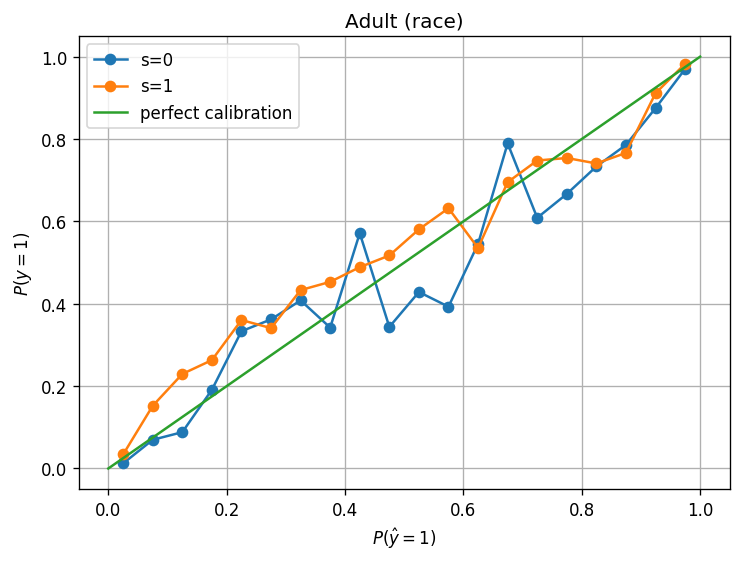

In [21]:
plot_calibration_per_group(pred_simple)

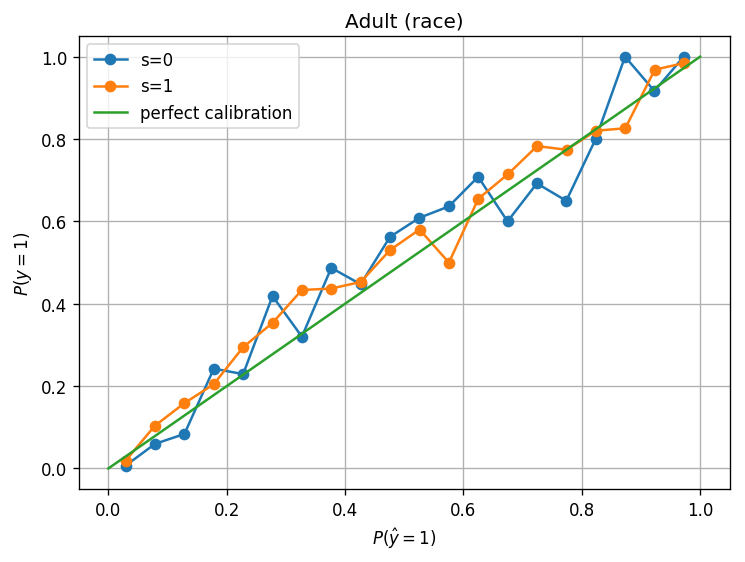

In [22]:
plot_calibration_per_group(pred_baseline)

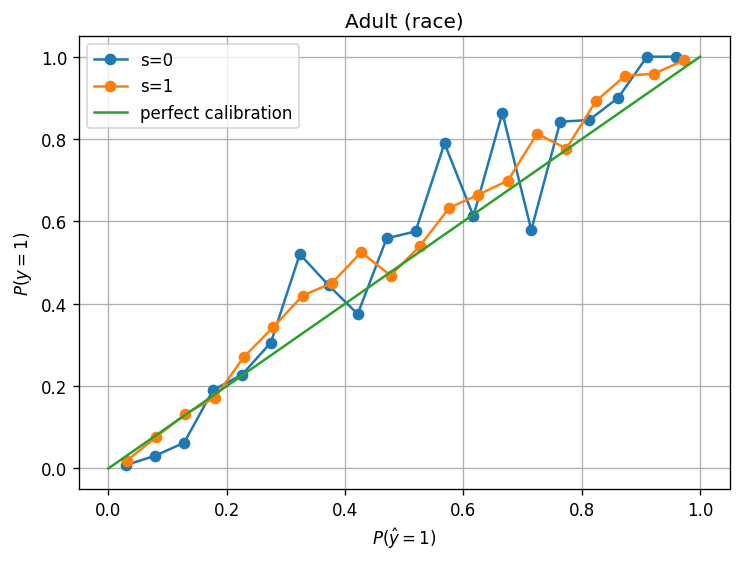

In [23]:
plot_calibration_per_group(pred_dropout)